In [1]:
import os
import random
import gc

import torch
import torchvision
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.cluster import KMeans

import cv2
from imutils import paths
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline

os.sys.path.append('../src')
from helpers import resize_to_fit

In [2]:
data_dir = os.path.abspath(os.path.relpath('../data'))
image_dir = os.path.abspath(os.path.relpath('../doc/images'))

In [3]:
CAPTCHA_IMAGES_FOLDER = "../data/samples"

# initialize the data and labels
data = []
labels = []

# loop over the input images
for image_file in paths.list_images(CAPTCHA_IMAGES_FOLDER):
    # Load the image and convert it to grayscale

    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Grab the labels
    label = image_file.split(os.path.sep)[-1].split('.')[-2]

    # Add the image and it's label to our training data
    data.append(image)
    labels.append(label)

In [4]:
(X_train, X_test, y_train, y_test) = train_test_split(data, labels, test_size=0.25, random_state=0)

In [5]:
def create_images(data, label):
    # Otsu threashold
    data_pre = []
    for e in data:
        ret, th = cv2.threshold(e, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        kernel = np.ones((3,3), np.uint8)
        dilation = cv2.dilate(th, kernel, iterations=1)
        erosion = cv2.erode(dilation, kernel, iterations=1)
        data_pre.append(erosion)
    
    # K-means
    data_pts = []
    for e in data_pre:
        data_pts.append(np.where(e == 0))
    data_pts = np.array(data_pts)
    
    X = []
    thres = 3
    for e in data_pts:
        x = (np.vstack((e[1],np.flip(e[0])))).T
        l = []
        # Discard columns with less than thres points
        for i in range(200):
            if len(x[x[:,0] == i]) > thres:
                for f in x[x[:,0] == i]:
                    l.append(f)
        x = np.array(l)
        X.append(x)
    X = np.array(X)
    
    # Projection in x-axis
    X_proj = [x[:,0].reshape(-1,1) for x in X]
    
    # Find clusters in projected data
    y_kmeans_proj = []
    centers_kmeans_proj = []
    for i, x in enumerate(X_proj):
        kmeans = KMeans(n_clusters=5)#, init=np.array([(i*200/6.0, 25) for i in range(1,6)]))
        kmeans.fit(x)
        centers_kmeans_proj.append(kmeans.cluster_centers_)
        y_kmeans_proj.append(kmeans.predict(x))

    centers = [np.sort(e, axis=0) for e in centers_kmeans_proj]
    data_chars = []
    for i, e in enumerate(data_pre):
        chars = []
        for j in range(5):
            chars.append(e[:,int(centers[i][j]-21):int(centers[i][j]+21)])
        data_chars.append(chars)
        
    return data_chars

In [6]:
letters_train_dir = '../data/letters/train'

data_chars = create_images(X_train, y_train)

if not(os.path.isdir(''.join((letters_train_dir)))):
    os.mkdir(''.join((letters_train_dir)))

for i,e in enumerate(data_chars):
    for j in range(5):
        if not(os.path.isdir(''.join((letters_train_dir,'/',y_train[i],'/')))):
            os.mkdir(''.join((letters_train_dir,'/',y_train[i],'/')))
        cv2.imwrite(''.join((letters_train_dir,'/',y_train[i],'/',str(j),'-',y_train[i][j],'.png')),e[j])

In [7]:
letters_test_dir = '../data/letters/test'

data_chars_test = create_images(X_test, y_test)

if not(os.path.isdir(''.join((letters_test_dir)))):
    os.mkdir(''.join((letters_test_dir)))

for i,e in enumerate(data_chars_test):
    for j in range(5):
        if not(os.path.isdir(''.join((letters_test_dir,'/',y_test[i],'/')))):
            os.mkdir(''.join((letters_test_dir,'/',y_test[i],'/')))
        cv2.imwrite(''.join((letters_test_dir,'/',y_test[i],'/',str(j),'-',y_test[i][j],'.png')),e[j])

In [8]:
LETTER_IMAGES_FOLDER = letters_train_dir

# initialize the data and labels
data_l_train = []
labels_l_train = []

# loop over the input images
for image_file in paths.list_images(LETTER_IMAGES_FOLDER):
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize the letter so it fits in a 28x28 pixel box
    image = resize_to_fit(image, 32, 32)

    # Add a third channel dimension to the image to make Keras happy
    image = np.expand_dims(image, axis=2)

    # Grab the name of the letter based on the folder it was in
    label = image_file.split(os.path.sep)[-1].split('.')[-2].split('-')[1]

    # Add the letter image and it's label to our training data
    data_l_train.append(image)
    labels_l_train.append(label)


In [9]:
LETTER_IMAGES_FOLDER = letters_test_dir

# initialize the data and labels
data_l_test = []
labels_l_test = []

# loop over the input images
for image_file in sorted(paths.list_images(LETTER_IMAGES_FOLDER)):
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize the letter so it fits in a 28x28 pixel box
    image = resize_to_fit(image, 32, 32)

    # Add a third channel dimension to the image to make Keras happy
    image = np.expand_dims(image, axis=2)

    # Grab the name of the letter based on the folder it was in
    label = image_file.split(os.path.sep)[-1].split('.')[-2].split('-')[1]

    # Add the letter image and it's label to our training data
    data_l_test.append(image)
    labels_l_test.append(label)

In [10]:
np.shape(data_l_test)

(1340, 32, 32, 1)

In [11]:
# scale the raw pixel intensities to the range [0, 1] (this improves training)
X_l_train = np.array(data_l_train, dtype="float") / 255.0
X_l_test = np.array(data_l_test, dtype="float") / 255.0

In [12]:
# Convert the labels (letters) into one-hot encodings that Keras can work with
le = LabelEncoder().fit(np.array((labels_l_train + labels_l_test)))
y_l_train = le.transform(np.array(labels_l_train))
y_l_test = le.transform(np.array(labels_l_test))

In [13]:
batch_size_train = 100
batch_size_test = 1000

In [14]:
X_l_train_t = (torch.from_numpy(X_l_train).float().transpose(1,3)).transpose(2,3)
y_l_train_t = torch.from_numpy(y_l_train).long()

train_data = torch.utils.data.TensorDataset(X_l_train_t, y_l_train_t)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=round(batch_size_train), shuffle=True)

In [15]:
X_l_test_t = (torch.from_numpy(X_l_test).float().transpose(1,3)).transpose(2,3)
y_l_test_t = torch.from_numpy(y_l_test).long()

test_data = torch.utils.data.TensorDataset(X_l_test_t, y_l_test_t)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test, shuffle=True)

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(400, 340)
        self.fc2 = nn.Linear(340, 19)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 400)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return F.log_softmax(x, dim=0)

In [17]:
def train(epoch, v=False):
    net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = net(data)
        loss = F.nll_loss(output, target, reduction='mean')
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            if v:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
        torch.save(net.state_dict(), 'model.pth')
        torch.save(optimizer.state_dict(), 'optimizer.pth')

In [18]:
def test():
    net.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = net(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [19]:
learning_rate = 0.01
log_interval = 10
n_epochs = 100

In [20]:
net = Net()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [21]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [22]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()


Test set: Avg. loss: 6.6337, Accuracy: 74/1340 (5%)


Test set: Avg. loss: 5.1017, Accuracy: 936/1340 (69%)


Test set: Avg. loss: 4.6631, Accuracy: 1153/1340 (86%)


Test set: Avg. loss: 4.4741, Accuracy: 1163/1340 (86%)


Test set: Avg. loss: 4.4315, Accuracy: 1200/1340 (89%)


Test set: Avg. loss: 4.2658, Accuracy: 1220/1340 (91%)


Test set: Avg. loss: 4.3556, Accuracy: 1227/1340 (91%)


Test set: Avg. loss: 4.2541, Accuracy: 1239/1340 (92%)


Test set: Avg. loss: 4.2015, Accuracy: 1255/1340 (93%)


Test set: Avg. loss: 4.1299, Accuracy: 1259/1340 (93%)


Test set: Avg. loss: 4.1523, Accuracy: 1265/1340 (94%)


Test set: Avg. loss: 4.1453, Accuracy: 1258/1340 (93%)


Test set: Avg. loss: 4.0992, Accuracy: 1262/1340 (94%)


Test set: Avg. loss: 4.1191, Accuracy: 1268/1340 (94%)


Test set: Avg. loss: 4.0765, Accuracy: 1269/1340 (94%)


Test set: Avg. loss: 4.1048, Accuracy: 1262/1340 (94%)


Test set: Avg. loss: 4.0936, Accuracy: 1257/1340 (93%)


Test set: Avg. loss: 4.0529, Accur

In [23]:
LETTER_IMAGES_FOLDER = '../data/letters/test'


# initialize the data and labels
data_test = []
labels_test = []

# loop over the input images
for d in os.listdir(LETTER_IMAGES_FOLDER):
    aux = []
    for image_file in sorted(paths.list_images(LETTER_IMAGES_FOLDER + '/' + d)):
        # Load the image and convert it to grayscale
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Resize the letter so it fits in a 28x28 pixel box
        image = resize_to_fit(image, 32, 32)

        # Add a third channel dimension to the image to make Keras happy
        image = np.expand_dims(image, axis=2)
        aux.append(image)
        


    data_test.append(aux)
    labels_test.append(d)

In [24]:
np.shape(data_test[2])

(5, 32, 32, 1)

In [25]:
pred_test = []

for i, e in enumerate(labels_test):
    x = np.array(data_test[i], dtype="float") / 255.0
    x = (torch.from_numpy(x).float().transpose(1,3)).transpose(2,3)
    out = net(x)
    pred = out.data.max(1, keepdim=True)[1]
    y = (''.join([e for e in le.inverse_transform(np.ravel(pred))]))
    pred_test.append(y)

In [26]:
correct = 0
for e, f in zip(pred_test, labels_test):
    print(e, f)
    if e == f:
        correct += 1
correct

n3c6y d3c8y
ny52p ny5dp
675g3 675p3
g4cx3 g3ex3
e2d5n 22d5n
5pcbw xbcbx
2g783 2g783
3b7xf 3d7bd
f2fge f2fge
7ynge 7gnge
w7652 37d52
864dn 664dn
5ng6e 5ng6e
g7w6y g7wxw
6cn48 62nb3
6byng 6bxwg
gpbwn dpbyd
wm47f wm47f
ybncw wbncw
532fm 5325m
2n78f 2n73f
n2y3x dy3cx
3cpwb 3cpwb
dw6mn dw6mn
5n243 5n245
4n2yg 4n2yg
573e8 573d8
n7g4f n7g4f
8y63f 8y63f
7y3eb ny3nn
2xcbn 2xc2n
658xc 658xe
x2f4e x277e
bmy2x nmy2x
nbwpg nbwpn
xw7nc yw7ny
cpwe6 c6we6
bgp68 bgb48
pxcn8 wxcn8
g7n8p 4743p
dc45x de45x
gc83b gc83b
gw468 gw468
25m6p 25m6p
7g4nf 7g3nf
76y5f 76y6f
3m26n dn26n
bgxcd bgxcd
b7men b2nen
fbp2c fbp2c
nmx8p dmx8p
d4n82 d4n82
p6m48 p6mn8
yw75g yyg5g
c7gb3 c7gb3
cfm34 efx34
bg2y8 ng2gw
y5g87 y5g87
3n4wx nn4wx
f576m w7e6m
4pg7m 4egem
4gb3f 4gb3f
cfw3n dw3nn
nwc57 nnn57
6dnx7 6dmx7
p8w5f p8wwf
3p4nm 3p4nn
3w7g2 387g2
8f4n4 x44n4
2bf7m 33f7m
43mn5 43mn5
4e2y7 7e2y7
x4nyg xemyg
exycn exycn
265cm 8684m
y48c3 y48c3
fdxpn mdxpn
dxy28 dnmd8
p8ngx p8ngx
64b3p 64b3p
4gc2f bnc2f
w4cnb w4cnn
c6745 c6745
mc5d

87

In [27]:
correct/len(pred_test)

0.3246268656716418

In [48]:
incorrect = len(pred_test) - correct
mnproblem = 0
for e, f in zip(pred_test, labels_test):
    if e != f:
        if (('m' in e and 'm' not in f) or
            ('m' in f and 'm' not in e) or
            ('n' in e and 'n' not in f) or
            ('n' in f and 'n' not in e)):
                mnproblem += 1
print(mnproblem/incorrect)

0.3701657458563536


In [49]:
mnproblem/len(pred_test)

0.25

In [32]:
def confusion(y_hat, y, n_classes):
    ans = np.zeros((n_classes, n_classes))
    for i, (e, f) in enumerate(zip(y, y_hat)):
        ans[classes.index(e)][int(f)] += 1
    return ans


In [33]:
classes = list(le.classes_)

In [34]:
print(classes)
cm = confusion(pred_test, labels_test, len(classes))

['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


ValueError: 'd3c8y' is not in list

In [ ]:
LETTER_IMAGES_FOLDER = letters_test_dir

# initialize the data and labels
data_l_test = []
labels_l_test = []

# loop over the input images
for image_file in sorted(paths.list_images(LETTER_IMAGES_FOLDER)):
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize the letter so it fits in a 28x28 pixel box
    image = resize_to_fit(image, 32, 32)

    # Add a third channel dimension to the image to make Keras happy
    image = np.expand_dims(image, axis=2)

    # Grab the name of the letter based on the folder it was in
    label = image_file.split(os.path.sep)[-1].split('.')[-2].split('-')[1]

    # Add the letter image and it's label to our training data
    data_l_test.append(image)
    labels_l_test.append(label)

In [42]:
with torch.no_grad():
    output = net(test_loader.dataset.tensors[0])
    pred = output.data.max(1, keepdim=True)[1]
    target_l = test_loader.dataset.tensors[1]

In [43]:
def performance_matrix(true,pred):
    precision = metrics.precision_score(true,pred,average='macro')
    recall = metrics.recall_score(true,pred,average='macro')
    accuracy = metrics.accuracy_score(true,pred)
    f1_score = metrics.f1_score(true,pred,average='macro')
    print('Confusion Matrix:\n',metrics.confusion_matrix(true, pred))
    print('Precision: {} Recall: {}, Accuracy: {}: ,f1_score: {}'.format(precision*100,recall*100,accuracy*100,f1_score*100))

Confusion matrix, without normalization
[[ 64   1   0   1   0   1   0   0   0   0   1   0   0   0   0   0   0   0
    0]
 [  1  67   1   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0
    1]
 [  0   0  62   0   0   0   0   0   0   1   0   0   0   0   0   0   1   0
    0]
 [  0   0   0  53   1   0   0   0   0   0   0   0   0   0   1   0   1   1
    0]
 [  0   0   0   0  60   0   0   0   0   0   0   1   0   0   0   0   0   0
    0]
 [  0   1   0   0   0  64   0   0   0   1   0   2   0   0   0   0   2   0
    0]
 [  0   0   0   1   0   0  64   1   0   0   0   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0  62   0   0   0   0   0   0   1   0   0   1
    0]
 [  0   1   0   0   0   0   0   0  62   0   0   0   0   0   0   0   0   0
    0]
 [  0   0   0   1   0   0   0   0   0  65   0   1   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   1   0   0   1   0  63   0   0   1   0   0   0   0
    1]
 [  0   0   1   0   0   0   0   1   0   0   0  61   0   1   0   0   0

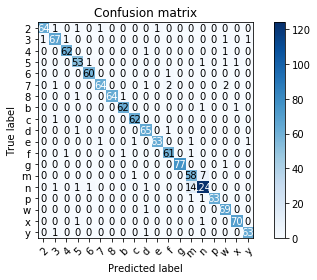

In [46]:
from sklearn import metrics

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'# Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        print(cm)
        fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')# Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")# Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
plot_confusion_matrix(target_l, pred, classes=le.classes_,title='Confusion matrix')